# 1D Inversion for 1D Data

In this notebook, we will invert secondary magnetic field data for a single 1D FDEM sounding using Weighted Least-Squares Method and Iteratively Reweighted Least-Square Method.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from discretize import TensorMesh

import SimPEG.electromagnetics.frequency_domain as fdem
from SimPEG.utils import mkvc, plot_1d_layer_model
from SimPEG import (
    maps,
    data,
    data_misfit,
    inverse_problem,
    regularization,
    optimization,
    directives,
    inversion,
)

import sys
sys.path.append("../")
from inversion_toolkit.model_functions import get_1d_model

import discretize
m_true = np.load("../models/2d-model-array.npy")
inversion_mesh_2d = discretize.load_mesh("../meshes/inversion_mesh_2d.json")

## Load Data and Plot

In [2]:
# path to the directory containing our data
dir_path = "./1d_simulation_data/"

In [3]:
# Choose which side data to work with
side = "right" # "right" or "left"

if side == "left":
    data_filename = dir_path + "em1dfm_data_left.txt"
    x_position = 0
elif side == "right":
    data_filename = dir_path + "em1dfm_data_right.txt"
    x_position = 10000
else:
    print("Invalid side chosen: No data")

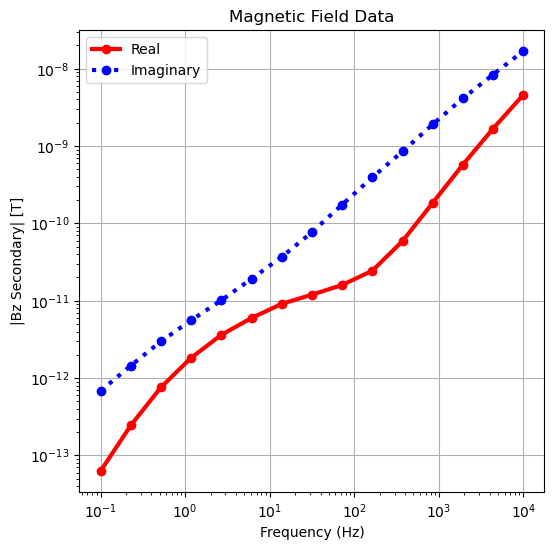

In [4]:
dobs = np.loadtxt(str(data_filename), skiprows=1)

# Define receiver locations and observed data
frequencies = dobs[:, 0]
dobs = mkvc(dobs[:, 1:].T)
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.loglog(frequencies, abs(dobs[0::2]), "r-o", lw=3)
ax.loglog(frequencies, abs(dobs[1::2]), "b:o", lw=3)
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("|Bz Secondary| [T]")
ax.set_title("Magnetic Field Data")
ax.legend(["Real", "Imaginary"])
plt.grid()
plt.show()

## Defining the Survey

In [5]:
source_location = np.array([0.0, 0.0, 30.0])
moment = 1.0

receiver_location = np.array([10.0, 0.0, 30.0])

# Receiver list
receiver_list = []
receiver_list.append(
    fdem.receivers.PointMagneticFluxDensitySecondary(
        receiver_location,
        orientation="z",
        component="real",
    )
)
receiver_list.append(
    fdem.receivers.PointMagneticFluxDensitySecondary(
        receiver_location,
        orientation="z",
        component="imag",
    )
)

# Define source list
source_list = []
for freq in frequencies:
    source_list.append(
        fdem.sources.MagDipole(
            receiver_list=receiver_list,
            frequency=freq,
            location=source_location,
            orientation="z",
            moment=moment,
        )
    )

# Survey
survey = fdem.survey.Survey(source_list)

## Assign Uncertainties

A percent uncertainty between 5% and 20% may be applied.

In [6]:
# 5% of the absolute value
uncertainties = 0.05 * np.abs(dobs) * np.ones(np.shape(dobs))

## Defining the Data

In [7]:
data_object = data.Data(survey, dobs=dobs, noise_floor=uncertainties)

## Weighted Least-Squares Inversion

Here, we use the weighted least-squares inversion approach to recover the log-resistivity on a 1D layered Earth. We impose no a-priori information about the number of layers (geological units) or their thicknesses. Instead, we define a large number of layers with exponentially increasing thicknesses. And the depth, thickness and electrical properties of the Earth are inferred from the recovered model.

### Defining a 1D Layered Earth (1D Tensor Mesh)

First assuming we have a reasonable estimate of the regional coductivity ($\sigma$) within our are of interest, estimate maximum and minimum skin depth:

$$d \approx 500\sqrt{\frac{1}{\sigma f}} = 500\sqrt{\frac{\rho}{f}} $$

In [8]:
# estimated host conductivity (S/m)
estimated_resistivity = 100

# minimum skin depth
d_min = 500.0 * np.sqrt(estimated_resistivity/ frequencies.max())
print("MINIMUM SKIN DEPTH: {} m".format(d_min))

# maximum skin depth
d_max = 500.0 * np.sqrt(estimated_resistivity/ frequencies.min())
print("MAXIMUM SKIN DEPTH: {} m".format(d_max))

MINIMUM SKIN DEPTH: 50.0 m
MAXIMUM SKIN DEPTH: 15811.388300841896 m


In [9]:
depth_min = 50  # top layer thickness
depth_max = 5000.0  # depth to lowest layer
geometric_factor = 1.2  # rate of thickness increase

In [10]:
# Increase subsequent layer thicknesses by the geometric factors until
# it reaches the maximum layer depth.
layer_thicknesses = [depth_min]
while np.sum(layer_thicknesses) < depth_max:
    layer_thicknesses.append(geometric_factor * layer_thicknesses[-1])

n_layers = len(layer_thicknesses) + 1  # Number of layers
print("n_layers: ", n_layers)

n_layers:  18


### Model and Mapping to Layer Conductivities

In [11]:
log_resistivity_map = maps.ExpMap(nP=n_layers)

### Define a Starting and/or Reference Model and the Mapping

Here, we create starting and/or reference models for the inversion as
well as the mapping from the model space to the active cells. Starting and
reference models can be a constant background value or contain a-priori
structures. Here, the starting model is log(estimated_resistivity) S/m.

Define log-resistivity values for each layer since our model is the
log-resistivity.



In [12]:
# Starting model is log-conductivity values (S/m)
starting_resistivity_model = np.log((estimated_resistivity) * np.ones(n_layers))

# Reference model is also log-resistivity values (S/m)
reference_resistivity_model = starting_resistivity_model.copy()

### Define the Physics using Simulation Object

In [13]:
simulation_L2 = fdem.Simulation1DLayered(
    survey=survey, thicknesses=layer_thicknesses, rhoMap=log_resistivity_map
)

### Define Inverse Problem

The inverse problem is defined by 3 things:

    1) Data Misfit: a measure of how well our recovered model explains the field data
    2) Regularization: constraints placed on the recovered model and a priori information
    3) Optimization: the numerical approach used to solve the inverse problem

In [14]:
# Define the data misfit. Here the data misfit is the L2 norm of the weighted
# residual between the observed data and the data predicted for a given model.
# The weighting is defined by the reciprocal of the uncertainties.
dmis_L2 = data_misfit.L2DataMisfit(simulation=simulation_L2, data=data_object)

In [15]:
# Define 1D cell widths
h = np.r_[layer_thicknesses, layer_thicknesses[-1]]
h = np.flipud(h)

# Create regularization mesh
regularization_mesh = TensorMesh([h], "N")
print(regularization_mesh)


  TensorMesh: 18 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x     18     -6,220.95         -0.00     50.00    924.42    1.20




In [16]:
reg_L2 = regularization.WeightedLeastSquares(
    regularization_mesh,
    length_scale_x=10.0,
    reference_model=reference_resistivity_model,
    reference_model_in_smooth=False,
)

In [17]:
opt_L2 = optimization.InexactGaussNewton(
    maxIter=100, maxIterLS=20, maxIterCG=20, tolCG=1e-3
)

### Define Inversion Directives

Here we define any directiveas that are carried out during the inversion. This
includes the cooling schedule for the trade-off parameter (beta), stopping
criteria for the inversion and saving inversion results at each iteration.

In [18]:
inv_prob_L2 = inverse_problem.BaseInvProblem(dmis_L2, reg_L2, opt_L2)

In [19]:
update_jacobi = directives.UpdatePreconditioner(update_every_iteration=True)
starting_beta = directives.BetaEstimate_ByEig(beta0_ratio=1e0)
beta_schedule = directives.BetaSchedule(coolingFactor=2.0, coolingRate=3)
target_misfit = directives.TargetMisfit(chifact=1.0)

directives_list_L2 = [
                      update_jacobi, 
                      starting_beta, 
                      beta_schedule, 
                      target_misfit,
                      ]

In [20]:
# Here we combine the inverse problem and the set of directives
inv_L2 = inversion.BaseInversion(inv_prob_L2, directives_list_L2)

# Run the inversion
recovered_model_L2 = inv_L2.run(starting_resistivity_model)

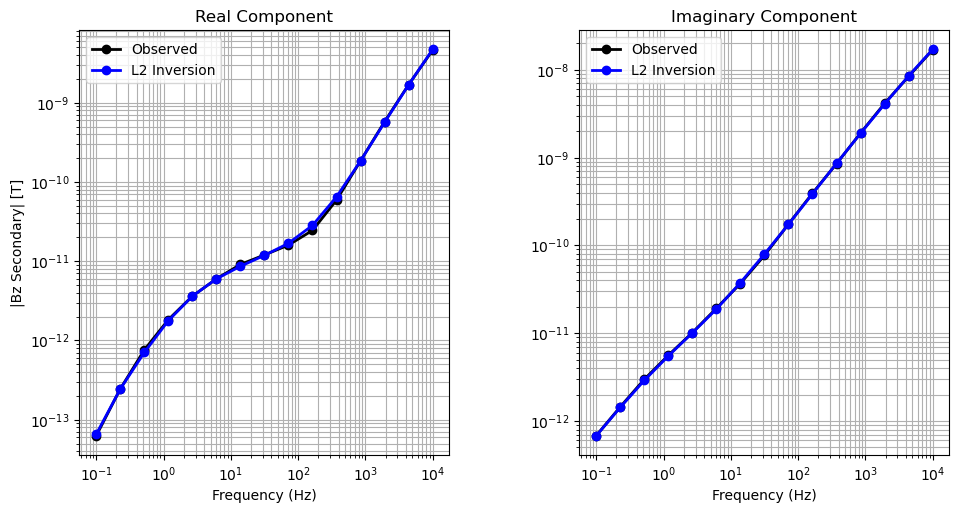

In [90]:
dpred_L2 = simulation_L2.dpred(recovered_model_L2)

fig = plt.figure(figsize=(10, 5))
ax = [fig.add_axes([0.1 + ii * 0.5, 0.1, 0.37, 0.85]) for ii in range(2)]
for ii in range(2):
    ax[ii].loglog(frequencies, abs(dobs[ii::2]), "k-o", lw=2)
    ax[ii].loglog(frequencies, abs(dpred_L2[ii::2]),"b-o", lw=2)
    ax[ii].grid(which="both")
    ax[ii].set_xlabel("Frequency (Hz)")
    ax[ii].set_ylabel("|Bz Secondary| [T]")
    ax[ii].legend(["Observed", "L2 Inversion"])
    if ii == 1:
        ax[ii].set_ylabel("")

ax[0].set_title("Real Component")
ax[1].set_title("Imaginary Component")
plt.show()

In [82]:
# Get true models
true_layers,true_log_resistivity_map, true_log_resistivities,_ = get_1d_model(x_position=x_position, 
                                                                              m_true=m_true,
                                                                              inversion_mesh_2d=inversion_mesh_2d)
true_resistivities = true_log_resistivity_map*true_log_resistivities

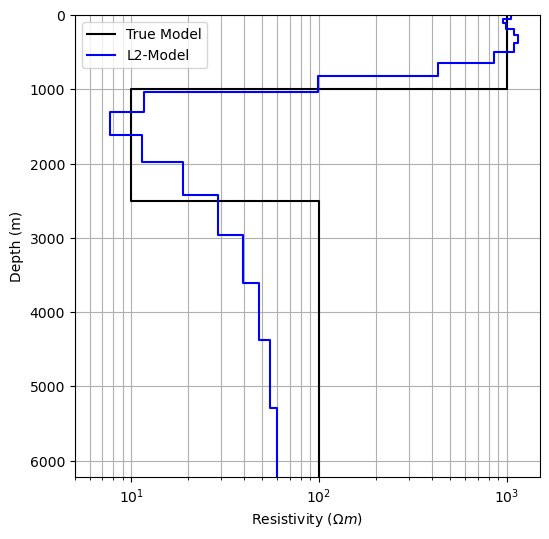

In [94]:
# Plot true model and recovered model
fig, ax = plt.subplots(1,1, figsize=(6, 6))

plot_1d_layer_model(true_layers, true_resistivities, scale="log", ax=ax, color="k")
plot_1d_layer_model(layer_thicknesses, log_resistivity_map * recovered_model_L2, ax=ax, color="b")
ax.grid(which="both")
ax.set_xlabel(r"Resistivity ($\Omega m$)")
x_min, x_max = true_resistivities.min(), true_resistivities.max()
ax.set_xlim(0.5 * x_min, 1.5 * x_max)
ax.legend(["True Model", "L2-Model"])
plt.show()

## Iteratively Re-weighted Least-Squares Inversion

Here, we use the iteratively reweighted least-squares (IRLS) inversion approach to recover sparse and/or blocky models on the set layers.

Need to redefine the geometric factor:

In [24]:
depth_min = 50  # top layer thickness
depth_max = 5000.0  # depth to lowest layer
geometric_factor = 1.5  # rate of thickness increase

Need to redefine everythong that depends on the geometric factor:

In [25]:
# Increase subsequent layer thicknesses by the geometric factors until
# it reaches the maximum layer depth.
layer_thicknesses_irls = [depth_min]
while np.sum(layer_thicknesses_irls) < depth_max:
    layer_thicknesses_irls.append(geometric_factor * layer_thicknesses_irls[-1])

n_layers = len(layer_thicknesses_irls) + 1  # Number of layers
print("n_layers: ", n_layers)

log_resistivity_map_irls = maps.ExpMap(nP=n_layers)

# Starting model is log-conductivity values (S/m)
starting_resistivity_model = np.log((estimated_resistivity) * np.ones(n_layers))

# Reference model is also log-resistivity values (S/m)
reference_resistivity_model = starting_resistivity_model.copy()

# Define 1D cell widths
h = np.r_[layer_thicknesses_irls, layer_thicknesses_irls[-1]]
h = np.flipud(h)

# Create regularization mesh
regularization_mesh = TensorMesh([h], "N")
print(regularization_mesh)

n_layers:  11

  TensorMesh: 11 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x     11     -7,588.67          0.00     50.00  1,922.17    1.50




### Define the Forward Simulation

In [26]:
simulation_irls = fdem.simulation_1d.Simulation1DLayered(
    survey=survey,
    rhoMap=log_resistivity_map_irls,
    thicknesses=layer_thicknesses_irls,
)

### Define the Data Misfit

In [27]:
dmis_irls = data_misfit.L2DataMisfit(simulation=simulation_irls, data=data_object)

### Regularization
Here, we use the Sparse regularization class to constrain the inversion result using an IRLS approach. Here, the scaling constants that balance the smallness and smoothness terms are set directly. Equal emphasis on smallness and smoothness is generally applied by using the inverse square of the smallest cell dimension.

In [28]:
reg_irls = regularization.Sparse(
    regularization_mesh,
    alpha_s=0.01,
    alpha_x=1,
    reference_mode= reference_resistivity_model,
    reference_model_in_smooth=True,
    norms=[1.0, 1.0],
)

### Optimization

In [29]:
opt_irls = optimization.InexactGaussNewton(
    maxIter=100, maxIterLS=20, maxIterCG=30, tolCG=1e-3
)

In [30]:
inv_prob_irls = inverse_problem.BaseInvProblem(dmis_irls, reg_irls, opt_irls)

### Directives
Here, we create common directives for IRLS inversion of total magnetic intensity data and describe their roles. In additon to the UpdateSensitivityWeights, UpdatePreconditioner and BetaEstimate_ByEig (described before), inversion with sparse-norms requires the Update_IRLS directive.

You will notice that we don’t use the BetaSchedule and TargetMisfit directives. Here, the beta cooling schedule is set in the Update_IRLS directive using the coolingFactor and coolingRate properties. The target misfit for the L2 portion of the IRLS approach is set with the chifact_start property.

In [31]:
starting_beta_irls = directives.BetaEstimate_ByEig(beta0_ratio=1e0)
update_jacobi_irls = directives.UpdatePreconditioner(update_every_iteration=True)
update_irls = directives.Update_IRLS(
    coolingFactor=2,
    coolingRate=3,
    f_min_change=1e-4,
    max_irls_iterations=30,
    chifact_start=1.0,
)

directives_list_irls = [update_irls, starting_beta_irls, update_jacobi_irls]

### Define and Run the Inversion

In [32]:
inv_irls = inversion.BaseInversion(inv_prob_irls, directives_list_irls)

# Run the inversion
recovered_model_irls = inv_irls.run(starting_resistivity_model)

SimPEG.InvProblem will set Regularization.reference_model to m0.
SimPEG.InvProblem will set Regularization.reference_model to m0.

                        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation1DLayered problem***
                        
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0


   0  2.82e+04  3.82e+05  0.00e+00  3.82e+05    6.35e+05      0              
   1  2.82e+04  1.50e+05  3.35e+00  2.44e+05    1.06e+05      0              
   2  2.82e+04  1.82e+05  2.04e+00  2.39e+05    4.64e+04      0              
   3  1.41e+04  1.67e+05  2.52e+00  2.03e+05    1.23e+05      0              
   4  1.41e+04  1.12e+05  5.70e+00  1.92e+05    3.86e+04      0              
   5  1.41e+04  1.28e+05  4.45e+00  1.91e+05    2.02e+04      0              
   6  7.06e+03  1.20e+05  5.00e+00  1.56e+05    8.84e+04      0              
   7  7.06e+03  7.35e+04  1.04e+01  1.47e+05    2.91e+04      0              
   8  7.06e+03  8.89e+04  8.07e+00  1.46e+05    1.89e+04      0              
   9  3.53e+03  8.03e+04  9.25e+00  1.13e+05    5.70e+04      0              
  10  3.53e+03  4.61e+04  1.71e+01  1.06e+05    1.86e+04      0              
  11  3.53e+03  5.77e+04  1.37e+01  1.06e+05    1.35e+04      0              
  12  1.76e+03  5.07e+04  1.56e+01  7.82e+04    3.58e+04      0 

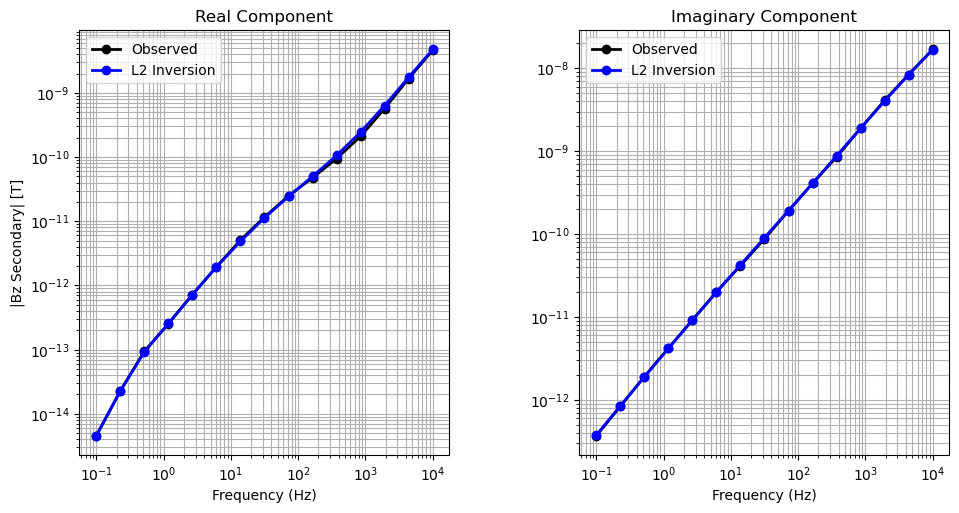

In [33]:
dpred_irls = simulation_irls.dpred(recovered_model_irls)

fig = plt.figure(figsize=(10, 5))
ax = [fig.add_axes([0.1 + ii * 0.5, 0.1, 0.37, 0.85]) for ii in range(2)]
for ii in range(2):
    ax[ii].loglog(frequencies, abs(dobs[ii::2]), "k-o", lw=2)
    ax[ii].loglog(frequencies, abs(dpred_irls[ii::2]),"b-o", lw=2)
    ax[ii].grid(which="both")
    ax[ii].set_xlabel("Frequency (Hz)")
    ax[ii].set_ylabel("|Bz Secondary| [T]")
    ax[ii].legend(["Observed", "L2 Inversion"])
    if ii == 1:
        ax[ii].set_ylabel("")

ax[0].set_title("Real Component")
ax[1].set_title("Imaginary Component")
plt.show()

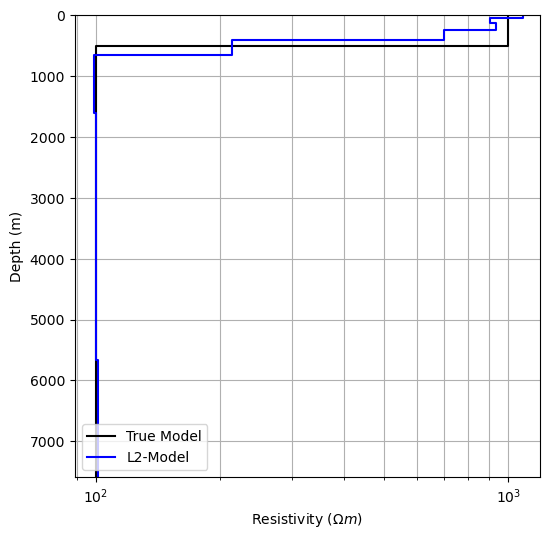

In [34]:
# Plot true model and recovered model
fig, ax = plt.subplots(1,1, figsize=(6, 6))

plot_1d_layer_model(true_layers, true_resistivities, scale="log", ax=ax, color="k")
plot_1d_layer_model(layer_thicknesses_irls, log_resistivity_map_irls * recovered_model_irls, ax=ax, color="b")
ax.grid(which="both")
ax.set_xlabel(r"Resistivity ($\Omega m$)")
x_min, x_max = true_resistivities.min(), true_resistivities.max()
# ax.set_xlim(0.5 * x_min, 1.5 * x_max)
ax.legend(["True Model", "L2-Model"])
plt.show()

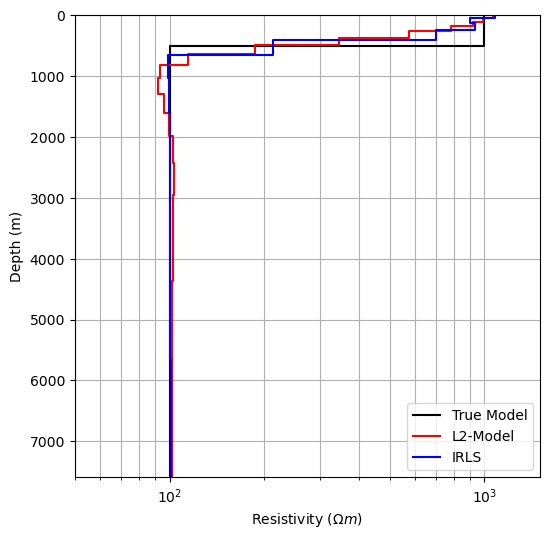

In [35]:
# Plot true model and recovered model
fig, ax = plt.subplots(1,1, figsize=(6, 6))

plot_1d_layer_model(true_layers, true_resistivities, scale="log", ax=ax, color="k")
plot_1d_layer_model(layer_thicknesses, log_resistivity_map * recovered_model_L2, ax=ax, color="r")
plot_1d_layer_model(layer_thicknesses_irls, log_resistivity_map_irls * recovered_model_irls, ax=ax, color="b")
ax.grid(which="both")
ax.set_xlabel(r"Resistivity ($\Omega m$)")
x_min, x_max = true_resistivities.min(), true_resistivities.max()
ax.set_xlim(0.5 * x_min, 1.5 * x_max)
ax.legend(["True Model", "L2-Model", "IRLS"], loc="lower right")
plt.show()